In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

fullTable = pd.read_csv('empAtt.csv')

In [35]:
s=fullTable.pivot_table(index=['Attrition'])
s

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,,,
0,37.561233,812.504461,8.915653,2.927007,1.0,1027.656123,2.771290,65.952149,2.770479,2.145985,...,2.733982,80.0,0.845093,11.862936,2.832928,2.781022,7.369019,4.484185,2.234388,4.367397
1,33.607595,750.362869,10.632911,2.839662,1.0,1010.345992,2.464135,65.573840,2.518987,1.637131,...,2.599156,80.0,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321


In [32]:
temp =fullTable[['TotalWorkingYears', 'Attrition']].corr() 
temp
val = temp['Attrition']['EnvironmentSatisfaction']
#val
temp
#sns.factorplot("JobSatisfaction","Attrition", data=finalTable,kind="bar",palette="Reds",size=6,aspect=2,legend_out=False);

,TotalWorkingYears,Attrition
TotalWorkingYears,1.000000,-0.171063
Attrition,-0.171063,1.000000


In [36]:
total =0
neWeight = pd.DataFrame(index=range(1,2))
for i in list(s):
    temp =fullTable[['Attrition', i]].corr() 
    val = temp['Attrition'][i]
    if(val<0):
        val *= -1

    if(val>=0.1):
        total += val
        neWeight[i]= val

grandTotal=0
for i in list(neWeight):
    neWeight[i]= round(100*neWeight[i]/total, 2)
    grandTotal += neWeight[i]

neWeight

,Age,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,OverTime,StockOptionLevel,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager
1,8.7,5.65,7.1,9.24,5.65,8.73,13.45,7.49,9.35,7.34,8.77,8.53


In [37]:
empScore = 0
#fullTable.extend('empScore')
fullTable['empScore']=0
#fullTable['clusters']=0

for i in list(neWeight):
    cols = [i,'Attrition']
    p_std = stats.zscore(fullTable[cols])
    kmeans = KMeans(n_clusters=2, random_state =0).fit(p_std)
    labels = kmeans.labels_
    fullTable['clusters']=labels
    cols.extend(['clusters'])
    c1 = len(fullTable[(fullTable['clusters']==0) & (fullTable['Attrition']==0)].index)
    c2 = len(fullTable[(fullTable['clusters']==1) & (fullTable['Attrition']==0)].index)
    c=0
    if(c1>c2):
        c=1
    centroid1 = fullTable[cols].groupby(['clusters']).mean()[i][c]
    centroid0 = fullTable[cols].groupby(['clusters']).mean()[i][1-c]
    
    for index,row in fullTable.iterrows():
        datapoint = row[i]
        diff1 = datapoint-centroid1
        if(diff1<0):
            diff1 *= -1
        diff0 = datapoint-centroid0
        if(diff0<0):
            diff0 *= -1
        mul = round(diff0/(diff0 + diff1),2)
        if(row['clusters']==c):
            fullTable.loc[index,'empScore'] += mul*neWeight[i][1]

usefulColumns = list(neWeight)
usefulColumns.append('Attrition')
usefulColumns.append('empScore')
finalTable =fullTable[usefulColumns]
print(finalTable)

      Age  EnvironmentSatisfaction  JobInvolvement  JobLevel  JobSatisfaction  \
0      41                        2               3         2                4   
1      49                        3               2         2                2   
2      37                        4               2         1                3   
3      33                        4               3         1                3   
4      27                        1               3         1                2   
5      32                        4               3         1                4   
6      59                        3               4         1                1   
7      30                        4               3         1                3   
8      38                        4               2         3                3   
9      36                        3               3         2                3   
10     35                        1               4         1                2   
11     29                   

In [38]:
x = fullTable[(fullTable['Attrition']==0) & (fullTable['empScore']>0)]
#print(x)
print('Count of employees who may probably quit in the future: ', len(x.index))

x = fullTable[fullTable['Attrition']==1]
print('Average score of employees who left office:',x['empScore'].mean())
#len(x.index)

Count of employees who may probably quit in the future:  289
Average score of employees who left office: 54.48193586497889


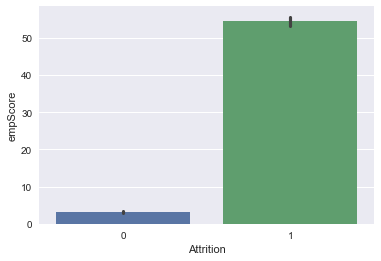

In [39]:
sns.barplot(x='Attrition',y='empScore',data=finalTable)

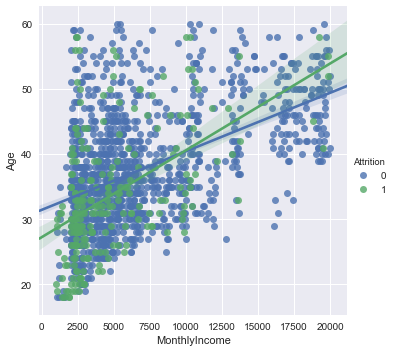

In [40]:
sns.lmplot('MonthlyIncome','Age', data=finalTable, hue="Attrition")#('empScore',data = finalTable,hue='Attrition')

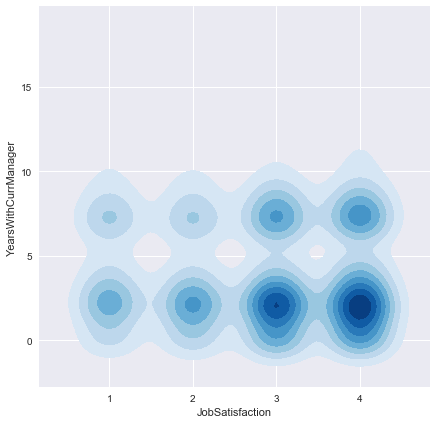

In [71]:
sns.set(style="darkgrid")

# Subset the iris dataset by species
stillHere = finalTable.query("Attrition == 0")
quitted = finalTable.query("Attrition == 1")

# Set up the figure
f, ax = plt.subplots(figsize=(7, 7))
ax.set_aspect("auto")

# Draw the two density plots

ax = sns.kdeplot(stillHere.JobSatisfaction, stillHere.YearsWithCurrManager, cmap="Blues", shade=True, shade_lowest=False)


# Add labels to the plot
blue = sns.color_palette("Blues")[-2]
#ax.text(2.5, 8.2, "virginica", size=16, color=blue)
#ax.text(3.8, 4.5, "setosa", size=16, color=red)


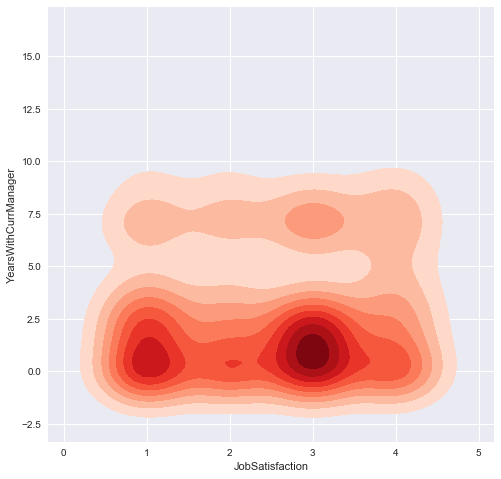

In [69]:
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("auto")
ax = sns.kdeplot(quitted.JobSatisfaction, quitted.YearsWithCurrManager,
                 cmap="Reds", shade=True, shade_lowest=False)


# Add labels to the plot
red = sns.color_palette("Reds")[-2]